# Sander van de Kamp
#### 500734351 
#### 05/03/2021
# Game sales 

In [29]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Analysis
### Goal
The goal for this dataset is to predict the Global sales of a game based on how well it sold in North America and how it was rated.
### shape
It contains 16719  rows with 16
### features
Analyse probleem
It contains 9 float numbers and 7 string values

In [30]:
df = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
print(df.dtypes)
print(df.head(5))

Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score          object
User_Count         float64
Developer           object
Rating              object
dtype: object
                       Name Platform  Year_of_Release         Genre Publisher  \
0                Wii Sports      Wii           2006.0        Sports  Nintendo   
1         Super Mario Bros.      NES           1985.0      Platform  Nintendo   
2            Mario Kart Wii      Wii           2008.0        Racing  Nintendo   
3         Wii Sports Resort      Wii           2009.0        Sports  Nintendo   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  Critic_

# Prediction
### Classification
Linear, random forest regressors and decision tree regressor.
### Hyperparams
The hyperparams that can be tweaked for the decision tree and random forest regressors are the number of estimators, to prevent over/undefitting the max features and max leaf nodes should be changed, for the random forest regressor the criterion to change the function to measure the quality of the splits.

In [31]:
tree_param = {
    'criterion': ['mae', 'mse'],
    'max_leaf_nodes': [10, 15, 25, 50, 75],
    'max_depth': [2, 3, 4, 5, 6]
}

forest_param = {
    'criterion': ['mse', 'mae'],
    'max_depth': [2, 3, 4, 5, 6],
    'max_leaf_nodes': [15, 25, 50]
}

# methoden
### Preprocessing
- The platform, genre, publisher and developer should be encoded to ints
- Drop unnecesary values and values with large numbers of missing values
- The outcome has to be an int , so multiply the value with 100
- Drop rows where there is no rating, user score, or critic score
- Drop rows that directly tie into the global sales values such as user count, JP,EU and other region sales. It would be a useless prediction when the answer can be read from 4 of the features in the dataset, which is why they should be dropped.

### Classifiers
The three models that will be compared are Random Forest, Decision tree and Linear regression.

### Metrics
The performance metric required is r², in this case it is not about being right or wrong but about how close the prediction is to the actual value.

In [32]:
print(len(df))
df.dropna(inplace = True)
print(len(df))

df['User_Score'] = (pd.to_numeric(df['User_Score']) * 10).astype('int')
df['Year_of_Release'] = df['Year_of_Release'].astype('int')
df['Critic_Score'] = df['Critic_Score'].astype('int')
df.drop(['Name'], axis = 1, inplace = True)

encoder = LabelEncoder()

encoder.fit(df['Platform'])
df['Platform'] = encoder.transform(df['Platform'])

encoder.fit(df['Genre'])
df['Genre'] = encoder.transform(df['Genre'])

encoder.fit(df['Publisher'])
df['Publisher'] = encoder.transform(df['Publisher'])

encoder.fit(df['Developer'])
df['Developer'] = encoder.transform(df['Developer'])

encoder.fit(df['Rating'])
df['Rating'] = encoder.transform(df['Rating'])

min_max = StandardScaler()
df_scaled = min_max.fit_transform(df.values)
df = pd.DataFrame(df_scaled, columns = df.columns)

16719
6825


# Visualisation
Heatmap visualisation to show the correlation matrix between the global sales and all the other variables. (predicted value is the global sales)

Any features that have a correlation below 0.2 and above -0.2 with the predicting value should be ignored since any fluctuations in the value of those values does not impact the predicted value. When a feature has a negative correlation it means that when the feature goes down, the predicted value goes up. This can also be used for predicting the outcome, but in this case all negative values are also too high to be used.

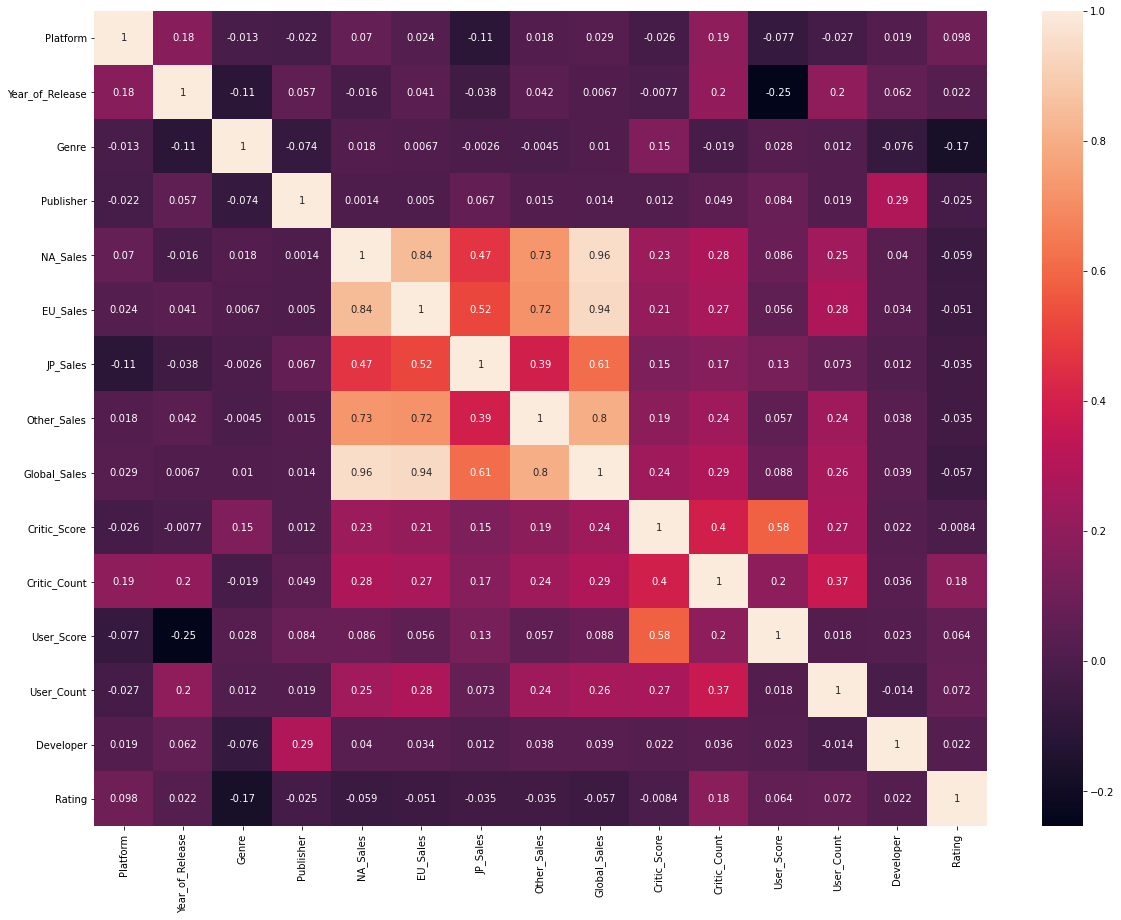

In [33]:
plt.figure(figsize = (20, 15))
heatmap = sns.heatmap(df.corr(), annot = True)

df_sales = df['Global_Sales'].astype('int')
df = df[['NA_Sales', 'Critic_Score', 'Critic_Count']]

X_train, X_test, y_train, y_test = train_test_split(df, df_sales, test_size = 0.3, random_state = 42)

# Classification
#

In [34]:
tree_grid = GridSearchCV(DecisionTreeRegressor(), tree_param, cv = 7, n_jobs = -1, return_train_score = True)
forest_grid = GridSearchCV(RandomForestRegressor(), forest_param, cv = 3, n_jobs = -1)

tree_grid.fit(X_train, y_train)
print('Best decision tree hyperparameters are \n{}'.format(tree_grid.best_params_))

forest_grid.fit(X_train, y_train)
print('Best random forest hyperparameters are \n{}'.format(forest_grid.best_params_))

lr = LinearRegression()
lr.fit(X_train, y_train)

Best decision tree hyperparameters are 
{'criterion': 'mae', 'max_depth': 4, 'max_leaf_nodes': 10}
Best random forest hyperparameters are 
{'criterion': 'mse', 'max_depth': 5, 'max_leaf_nodes': 15}


LinearRegression()

# results 


In [35]:
print('decisiong tree r2 score:{}'.format(r2_score(y_test, tree_grid.predict(X_test))))
print('random frest r2 score:{}'.format(r2_score(y_test, forest_grid.predict(X_test))))
print('Linear regression r2 score:{}'.format(r2_score(y_test, lr.predict(X_test))))

decisiong tree r2 score:0.7512465156452436
random frest r2 score:0.7370578047875618
Linear regression r2 score:0.6750990813572462


## Learning curve
Shows the accuracy of the model per param combination number 

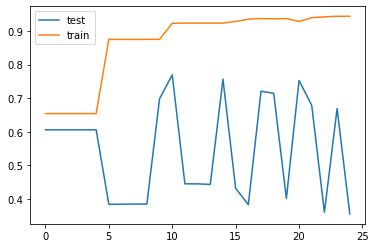

In [36]:
import matplotlib.pyplot as plt

test_scores = tree_grid.cv_results_['mean_test_score']
train_scores = tree_grid.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

# evaluation
Decision tree has an R2 score of 0.75, which is the highest of all three of the regressors. This score might not be the highest, but it does mean that it comes relatively close to predicting the right value.